# Deevio Data Scientist Hiring Challenge

## Preprocess images

In [173]:
images = glob.glob('input/**/*.jpeg')
len(images), images[:2]

(198, ['input/good/1522073189_good.jpeg', 'input/good/1522142649_good.jpeg'])

### Crop images 

In [174]:
import cv2
import tqdm

for image in tqdm.tqdm(images):
    
    fname = image.split('/')[-1]
    
    image = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    
    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)    
        if (w < 20 or w > 500) or (h < 20 or h > 500):
            continue
        c_x, c_y = x + w // 2, y + h // 2
        crop = image[c_y-112:c_y+112, c_x-112:c_x+112]
        
        if len(crop):            
            cv2.imwrite('input/images/' + fname, crop)

100%|██████████| 198/198 [00:03<00:00, 61.46it/s]


In [175]:
images = glob.glob('input/images/*.jpeg')
len(images)

186

### Load data

In [1]:
import glob
import numpy as np
import pandas as pd

df = pd.DataFrame(glob.glob('input/images/*.jpeg'), columns=['path']) 
df['label'] = df.path.apply(lambda x: x.split('.')[0].split('_')[-1])

print(df.shape, df.label.value_counts().to_dict())

df.head(2)

(186, 2) {'bad': 93, 'good': 93}


,path,label
0,input/images/1522073253_bad.jpeg,bad
1,input/images/1522074326_bad.jpeg,bad


'bad'

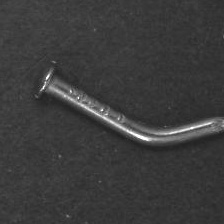

In [3]:
from IPython import display

sample = df.sample(1)

display.display(sample.label.values.item())
display.Image(sample.path.values.item(), width=224, height=224)

## Build ML pipeline

In [76]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [5]:
def load_image(x):    
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=1)
    return x

In [6]:
row = 3; col = 4;

ds = tf.data.Dataset.from_tensor_slices(df[df.label=='good'].path.values)
ds = ds.map(load_image)
ds = ds.repeat().batch(row*col)

### Display good images

Good


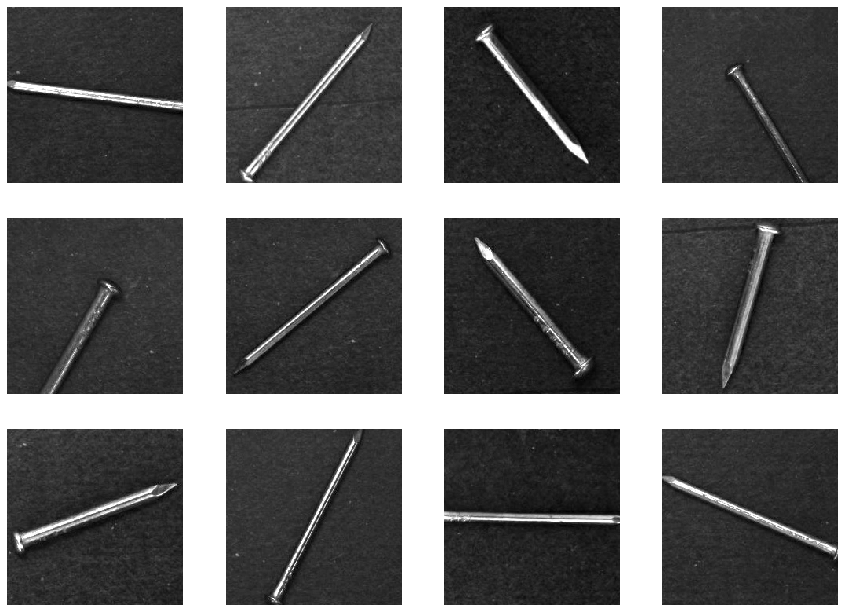

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Good")

for batch in ds:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(batch[j, :, :, 0], cmap='gray')
    plt.show()
    break

In [8]:
row = 3; col = 4;

ds = tf.data.Dataset.from_tensor_slices(df[df.label=='bad'].path.values)
ds = ds.map(load_image)
ds = ds.repeat().batch(row*col)

### Display bad images

Bad


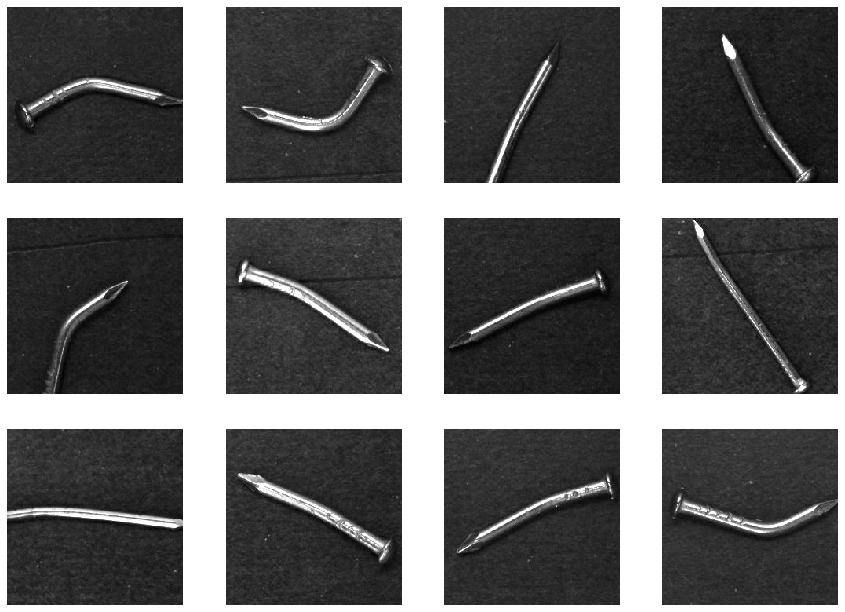

In [9]:
print("Bad")

for batch in ds:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(batch[j, :, :, 0], cmap='gray')
    plt.show()
    break

In [10]:
df['target'] = df.label.map({'good': 1, 'bad': 0})
df.head(2)

,path,label,target
0,input/images/1522073253_bad.jpeg,bad,0
1,input/images/1522074326_bad.jpeg,bad,0


### Split data

In [11]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.2, random_state=0, stratify=df.target)

train.shape, valid.shape, train.path.index.intersection(valid.path.index)

((148, 3), (38, 3), Int64Index([], dtype='int64'))

### Data augmentation

In [12]:
import tensorflow_addons as tfa

In [13]:
IMAGE_SIZE = [224, 224]
MARGIN = 48

@tf.function
def load_and_preprocess_image(x, training):
   
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.image.resize(x, IMAGE_SIZE)
    
    if training:
        x = tf.cond(tf.random.uniform([]) > 0.5, lambda: tfa.image.mean_filter2d(x, filter_shape=4), lambda: x)
        
        noise = tf.random.normal(shape=([*IMAGE_SIZE, 1]), stddev=0.1)
        x = tf.cond(tf.random.uniform([]) > 0.5, lambda: tf.add(tf.cast(noise, tf.float32), x), lambda: x)
    
        x = tf.image.random_brightness(x, max_delta=0.2)        

        height = tf.random.uniform([], minval=IMAGE_SIZE[0] - MARGIN, maxval=IMAGE_SIZE[0] + MARGIN, dtype=tf.int32)
        width = tf.random.uniform([], minval=IMAGE_SIZE[0] - MARGIN, maxval=IMAGE_SIZE[0] + MARGIN, dtype=tf.int32)
        x = tf.image.resize_with_crop_or_pad(x, target_height=height, target_width=width)

        k = tf.random.uniform(shape=[], minval=0, maxval=360, dtype=tf.float32)
        x = tfa.image.rotate(x, k)
        
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        
        x = tf.image.resize(x, IMAGE_SIZE)
    
    return x

def load_and_preprocess_from_path_label(path, label, training=None):
    return load_and_preprocess_image(path, training), label

def load_and_preprocess_from_path(path, training=None):
    return load_and_preprocess_image(path, training)

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train.path.values, train.target.values)
)
valid_ds = tf.data.Dataset.from_tensor_slices(
    (valid.path.values, valid.target.values)
)
train_ds, valid_ds

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>)

In [15]:
train_ds = train_ds.map(lambda path, label: load_and_preprocess_from_path_label(path, label, training=True))
valid_ds = valid_ds.map(lambda path, label: load_and_preprocess_from_path_label(path, label, training=False))

train_ds, valid_ds

(<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>)

In [16]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.shuffle(buffer_size=1000).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

train_ds, valid_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Display augmented images

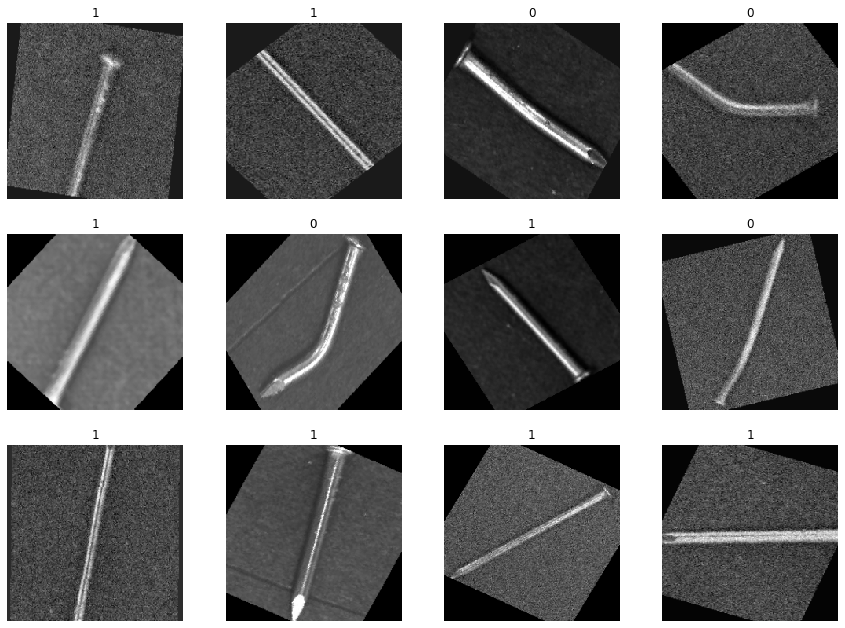

In [17]:
row = 3; col = 4;

ds = tf.data.Dataset.from_tensor_slices((train.path.values, train.target.values))
ds = ds.map(lambda path, label: load_and_preprocess_from_path_label(path, label, training=True))

ds = ds.repeat().batch(row*col)

for batch in ds:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(batch[0][j, :, :, 0], cmap='gray')
        plt.title(batch[1].numpy()[j,])
    plt.show()
    break

### Build model

In [38]:
radam = tfa.optimizers.RectifiedAdam(lr=1e-3)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

In [77]:
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB0(input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top=False)

model = tf.keras.Sequential([
    enet,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=ranger,
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_max_pooling2d_6 (Glob (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


### Train model

In [42]:
import os, datetime

MODEL_NAME ='2020-02-26'
DATE = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

if not os.path.exists(os.path.join('weights', MODEL_NAME)):
    os.makedirs(os.path.join('weights', MODEL_NAME))
    
# logdir = os.path.join('logs', MODEL_NAME, DATE)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=logdir, histogram_freq=0, write_images=True
# )

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(
        'weights', MODEL_NAME, 'epoch-{epoch:03d}' + '--' + 'val_accuracy-{val_accuracy:.3f}' + '.hdf5'
    ), monitor='val_accuracy', save_best_only=False, save_weights_only=False, mode='max', verbose=0
)

history = model.fit(
    train_ds, epochs=10, steps_per_epoch=100, callbacks=[
#         tensorboard_callback, 
#         lr_callback, 
        checkpoint_callback
    ], 
    validation_data=valid_ds, validation_steps=len(valid)//BATCH_SIZE+1,
#     class_weight=class_weight
)

Train for 100 steps, validate for 2 steps
Epoch 1/10
100/100 [==============================] - 53s 532ms/step - loss: 0.1053 - accuracy: 0.9609 - val_loss: 0.0633 - val_accuracy: 0.9688
Epoch 2/10
100/100 [==============================] - 24s 240ms/step - loss: 0.0917 - accuracy: 0.9638 - val_loss: 0.0378 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 25s 247ms/step - loss: 0.0880 - accuracy: 0.9681 - val_loss: 0.0358 - val_accuracy: 0.9844
Epoch 4/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0793 - accuracy: 0.9694 - val_loss: 0.0591 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0744 - accuracy: 0.9719 - val_loss: 0.0498 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0996 - accuracy: 0.9638 - val_loss: 0.0344 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0823 - ac

### Evaluate model

In [78]:
model.load_weights('weights/2020-02-26/epoch-006--val_accuracy-1.000.hdf5')

In [45]:
eval_ds = tf.data.Dataset.from_tensor_slices(
    (valid.path.values, valid.target.values)
)
eval_ds = eval_ds.map(lambda path, label: load_and_preprocess_from_path_label(path, label, training=False))
eval_ds = eval_ds.repeat(1).batch(BATCH_SIZE)

model.evaluate(eval_ds, steps=len(valid)//BATCH_SIZE+1)

2/2 [==============================] - 0s 124ms/step - loss: 0.0263 - accuracy: 1.0000


[0.026330347871407866, 1.0]

In [57]:
y_pred = model.predict(eval_ds, steps=len(valid), verbose=1)

 1/38 [..............................] - ETA: 2sWARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 38 batches). You may need to use the repeat() function when building your dataset.


In [63]:
y_pred = pd.Series(y_pred.flatten()).apply(lambda x: 1 if x > 0.5 else 0)

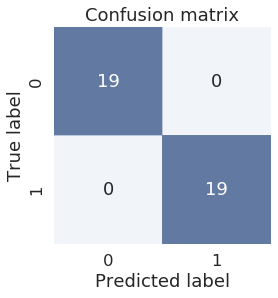

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(valid.target, y_pred)

plt.figure(figsize = (4,4))
sns.set(font_scale=1.5)

sns.heatmap(confmat, cbar=False, annot=True, square=True, fmt='.0f', cmap=plt.cm.Blues, alpha=0.6, annot_kws={'size': 18})

plt.title('Confusion matrix'), plt.xlabel('Predicted label'), plt.ylabel('True label')
plt.yticks(va='center'), plt.xticks(ha='center'), plt.show();

### Save model 

In [79]:
tf.saved_model.save(model, "tmp/efficientnet/1/")

INFO:tensorflow:Assets written to: tmp/efficientnet/1/assets


## TF Serving

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
def load_image(x):   
    
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.cast(x, tf.float32) / 255.0
    
    return tf.expand_dims(x, axis=0)

### Predict good image

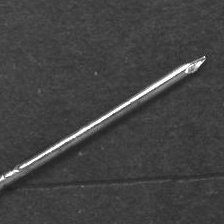

In [18]:
from IPython import display

image = 'data/1522073513_good.jpeg'
display.Image(image)

In [19]:
tensor = load_image(image)

In [20]:
import json

input_data_json = json.dumps(
    {
        "signature_name": "serving_default", 
        "instances": tensor.numpy().tolist(),
    }
)

In [21]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/efficientnet:predict'
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

response["predictions"]

[[0.998646915]]

### Predict bad image

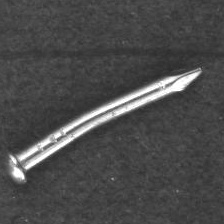

In [22]:
image = 'data/1522143004_bad.jpeg'
display.Image(image)

In [23]:
tensor = load_image(image)

In [24]:
input_data_json = json.dumps(
    {
        "signature_name": "serving_default", 
        "instances": tensor.numpy().tolist(),
    }
)

In [25]:
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

response["predictions"]

[[3.35664652e-09]]